Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.png)

# Training, hyperparameter tune, and deploy with Keras

## Introduction
This tutorial shows how to train a simple deep neural network using the MNIST dataset and Keras on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [configuration notebook](../../../configuration.ipynb) to:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)
* For local scoring test, you will also need to have `tensorflow` and `keras` installed in the current Jupyter kernel.

Let's get started. First let's import some Python libraries.

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.43


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [4]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: siamese-oneshot
Azure region: eastus2
Subscription id: 2f30e659-5d70-49f7-a8cf-0ba8cabc37f6
Resource group: default-storage-eastus


## Create an Azure ML experiment
Let's create an experiment named "keras-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [5]:
from azureml.core import Experiment

script_folder = './keras-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='keras-mnist')

## Download MNIST dataset
In order to train on the MNIST dataset we will first need to download it from Yan LeCun's web site directly and save them in a `data` folder locally.

In [6]:
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/mnist/test-labels.gz')

('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x7ff5db2fe4a8>)

## Show some sample images
Let's load the downloaded compressed file into numpy arrays using some utility functions included in the `utils.py` library file from the current folder. Then we use `matplotlib` to plot 30 random images from the dataset along with their labels.

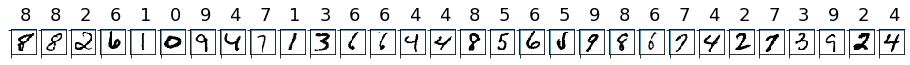

In [7]:
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

## Upload MNIST dataset to default datastore 
A [datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data) is a place where data can be stored that is then made accessible to a Run either by means of mounting or copying the data to the compute target. A datastore can either be backed by an Azure Blob Storage or and Azure File Share (ADLS will be supported in the future). For simple data handling, each workspace provides a default datastore that can be used, in case the data is not already in Blob Storage or File Share.

In [8]:
ds = ws.get_default_datastore()

In this next step, we will upload the training and test set into the workspace's default datastore, which we will then later be mount on an `AmlCompute` cluster for training.

In [9]:
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading ./data/mnist/test-images.gz
Uploading ./data/mnist/test-labels.gz
Uploading ./data/mnist/train-images.gz
Uploading ./data/mnist/train-labels.gz
Uploaded ./data/mnist/train-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist/test-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist/train-images.gz, 4 files out of an estimated total of 4


$AZUREML_DATAREFERENCE_224a9875a7f840b7b55270f243f9d944

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [10]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-06-18T21:14:00.885000+00:00', 'errors': None, 'creationTime': '2019-06-18T21:13:10.271769+00:00', 'modifiedTime': '2019-06-18T21:14:11.396025+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named "gpu-cluster" of type `AmlCompute`.

In [11]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

siamese-oneshot VirtualMachine Succeeded
gpu-cluster AmlCompute Succeeded


## Copy the training files into the script folder
The Keras training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [13]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./keras_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./keras-mnist/utils.py'

## Construct neural network in Keras
In the training script `keras_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

![DNN](nn.png)

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the file system folder in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the loss and accuracy at the end of each epoch via callback.
```
    run.log('Loss', log['loss'])
    run.log('Accuracy', log['acc'])
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect.

In [14]:
with open(os.path.join(script_folder, './keras_mnist.py'), 'r') as f:
    print(f.read())

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import argparse
import os

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.callbacks import Callback

import tensorflow as tf

from azureml.core import Run
from utils import load_data, one_hot_encode

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neurons', type=int, dest='n_hidden_1', default=100,
                    help='# of neurons in the first layer')
parser.add_argument('--second-layer-neurons', type=int, dest='n_hidd

## Create TensorFlow estimator & add Keras
Next, we construct an `azureml.train.dnn.TensorFlow` estimator object, use the `gpu-cluster` as compute target, and pass the mount-point of the datastore to the training code as a parameter.
The TensorFlow estimator is providing a simple way of launching a TensorFlow training job on a compute target. It will automatically provide a docker image that has TensorFlow installed. In this case, we add `keras` package (for the Keras framework obviously), and `matplotlib` package for plotting a "Loss vs. Accuracy" chart and record it in run history.

In [15]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ds.path('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.001
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 pip_packages=['keras', 'matplotlib'],
                 entry_script='keras_mnist.py', 
                 use_gpu=True)

WARNING - framework_version is not specified, defaulting to version 1.13.


And if you are curious, this is what the mounting point looks like:

In [16]:
print(ds.path('mnist').as_mount())

$AZUREML_DATAREFERENCE_fad5be8a967c42868e0a77a6819e0bd2


## Submit job to run
Submit the estimator to the Azure ML experiment to kick off the execution.

In [17]:
run = exp.submit(est)

### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [23]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 479, in _handle_results
    cache[job]._set(i, obj)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 649, in _set
    self._callback(self._value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/azureml/widgets/_userrun/_run_details.py", line 503, in _update_metrics
    self.widget_instance.run_metrics = result
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/anacon

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [20]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
keras-mnist,keras-mnist_1560893112_ece07ec9,azureml.scriptrun,Preparing,Link to Azure Portal,Link to Documentation


In [21]:
run.wait_for_completion(show_output=True)

RunId: keras-mnist_1560893112_ece07ec9
Web View: https://mlworkspace.azure.ai/portal/subscriptions/2f30e659-5d70-49f7-a8cf-0ba8cabc37f6/resourceGroups/default-storage-eastus/providers/Microsoft.MachineLearningServices/workspaces/siamese-oneshot/experiments/keras-mnist/runs/keras-mnist_1560893112_ece07ec9

Streaming azureml-logs/20_image_build_log.txt

2019/06/18 21:25:30 Downloading source code...
2019/06/18 21:25:32 Finished downloading source code
2019/06/18 21:25:32 Using acb_vol_ba2675de-fef4-4f18-b8cb-2815e04e8b77 as the home volume
2019/06/18 21:25:32 Creating Docker network: acb_default_network, driver: 'bridge'
2019/06/18 21:25:32 Successfully set up Docker network: acb_default_network
2019/06/18 21:25:32 Setting up Docker configuration...
2019/06/18 21:25:33 Successfully set up Docker configuration
2019/06/18 21:25:33 Logging in to registry: siameseonesheaa45350.azurecr.io
2019/06/18 21:25:34 Successfully logged into siameseonesheaa45350.azurecr.io
2019/06/18 21:25:34 Executin

  ERROR: Complete output from command /azureml-envs/azureml_57642d55fb33a477d2549fe0ee5ff8fd/bin/python -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-07sjosv5/horovod/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-255qg60m --python-tag cp36:
  Running setup.py clean for horovod
  ERROR: 
  Installed /tmp/pip-install-07sjosv5/horovod/.eggs/psutil-5.6.3-py3.6-linux-x86_64.egg
  Searching for cloudpickle
  Reading https://pypi.org/simple/cloudpickle/
  Best match: cloudpickle 1.2.1
  Processing cloudpickle-1.2.1-py2.py3-none-any.whl
  Installing cloudpickle-1.2.1-py2.py3-none-any.whl to /tmp/pip-install-07sjosv5/horovod/.eggs
  
  Installed /tmp/pip-install-07sjosv5/horovod/.eggs/cloudpickle-1.2.1-py3.6.egg
  Searching for cffi>=1.4.0
  Reading https://pypi.org/simple/cffi/
  Best match: cffi 1.12.3
  Processing c

  Stored in directory: /root/.cache/pip/wheels/90/7e/74/bb640d77775e6b6a78bcc3120f9fea4d2a28b2706de1cff37d
  Stored in directory: /root/.cache/pip/wheels/45/cb/7e/ce6e6062c69446e39e328170524ca8213498bc66a74c6a210b
  Stored in directory: /root/.cache/pip/wheels/f2/9a/90/de94f8556265ddc9d9c8b271b0f63e57b26fb1d67a45564511
Successfully built pyyaml absl-py gast termcolor psutil pathspec pycparser
Failed to build horovod
  Running setup.py install for horovod: started
    Running setup.py install for horovod: finished with status 'done'
#
# To activate this environment, use:
# > source activate /azureml-envs/azureml_57642d55fb33a477d2549fe0ee5ff8fd
#
# To deactivate an active environment, use:
# > source deactivate
#


Removing intermediate container 40be65defe88
 ---> fa6bfb7cf742
Step 9/14 : ENV PATH /azureml-envs/azureml_57642d55fb33a477d2549fe0ee5ff8fd/bin:$PATH
 ---> Running in c6f5dbd462b5
Removing intermediate container c6f5dbd462b5
 ---> 53ce5e632a2c
Step 10/14 : ENV AZUREML_CONDA_E

 - 5s - loss: 0.2171 - acc: 0.9353 - val_loss: 0.1080 - val_acc: 0.9658
Epoch 2/20
 - 3s - loss: 0.0933 - acc: 0.9718 - val_loss: 0.0787 - val_acc: 0.9752
Epoch 3/20
 - 3s - loss: 0.0664 - acc: 0.9810 - val_loss: 0.0759 - val_acc: 0.9776
Epoch 4/20
 - 3s - loss: 0.0506 - acc: 0.9851 - val_loss: 0.0840 - val_acc: 0.9788
Epoch 5/20
 - 3s - loss: 0.0392 - acc: 0.9885 - val_loss: 0.0815 - val_acc: 0.9806
Epoch 6/20
 - 3s - loss: 0.0327 - acc: 0.9904 - val_loss: 0.0949 - val_acc: 0.9797
Epoch 7/20
 - 3s - loss: 0.0278 - acc: 0.9917 - val_loss: 0.0868 - val_acc: 0.9796
Epoch 8/20
 - 3s - loss: 0.0223 - acc: 0.9939 - val_loss: 0.1122 - val_acc: 0.9768
Epoch 9/20
 - 3s - loss: 0.0187 - acc: 0.9941 - val_loss: 0.1064 - val_acc: 0.9801
Epoch 10/20
 - 3s - loss: 0.0167 - acc: 0.9951 - val_loss: 0.1012 - val_acc: 0.9828
Epoch 11/20
 - 3s - loss: 0.0150 - acc: 0.9958 - val_loss: 0.1335 - val_acc: 0.9763
Epoch 12/20
 - 4s - loss: 0.0128 - acc: 0.9964 - val_loss: 0.1431 - val_acc: 0.9784
Epoch 13/20


Exception in thread Thread-13:
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 479, in _handle_results
    cache[job]._set(i, obj)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 649, in _set
    self._callback(self._value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/azureml/widgets/_userrun/_run_details.py", line 503, in _update_metrics
    self.widget_instance.run_metrics = result
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/anacon

Logging experiment finalizing status in history service.
Cleaning up all outstanding Run operations, waiting 300.0 seconds
2 items cleaning up...
Cleanup took 0.2561929225921631 seconds


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 479, in _handle_results
    cache[job]._set(i, obj)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 649, in _set
    self._callback(self._value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/azureml/widgets/_userrun/_run_details.py", line 503, in _update_metrics
    self.widget_instance.run_metrics = result
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/anacon


Execution Summary
RunId: keras-mnist_1560893112_ece07ec9
Web View: https://mlworkspace.azure.ai/portal/subscriptions/2f30e659-5d70-49f7-a8cf-0ba8cabc37f6/resourceGroups/default-storage-eastus/providers/Microsoft.MachineLearningServices/workspaces/siamese-oneshot/experiments/keras-mnist/runs/keras-mnist_1560893112_ece07ec9



{'runId': 'keras-mnist_1560893112_ece07ec9',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2019-06-18T21:39:08.971976Z',
 'endTimeUtc': '2019-06-18T21:42:32.793772Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': 'fb17e59a-06b5-4ff7-aa02-4b49da282c18'},
 'runDefinition': {'script': 'keras_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_e8111a72044846ce837008b13a90d076',
   '--batch-size',
   '50',
   '--first-layer-neurons',
   '300',
   '--second-layer-neurons',
   '100',
   '--learning-rate',
   '0.001'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'gpu-cluster',
  'dataReferences': {'e8111a72044846ce837008b13a90d076': {'dataStoreName': 'workspaceblobstore',
    'mode': 'Mount',
    'pathOnDataStore': 'mnist',
    'pathOnCompute': None,
    'overwrite': False}},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': '

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [24]:
run.get_details()

{'runId': 'keras-mnist_1560893112_ece07ec9',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2019-06-18T21:39:08.971976Z',
 'endTimeUtc': '2019-06-18T21:42:32.793772Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': 'fb17e59a-06b5-4ff7-aa02-4b49da282c18'},
 'runDefinition': {'script': 'keras_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_e8111a72044846ce837008b13a90d076',
   '--batch-size',
   '50',
   '--first-layer-neurons',
   '300',
   '--second-layer-neurons',
   '100',
   '--learning-rate',
   '0.001'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'gpu-cluster',
  'dataReferences': {'e8111a72044846ce837008b13a90d076': {'dataStoreName': 'workspaceblobstore',
    'mode': 'Mount',
    'pathOnDataStore': 'mnist',
    'pathOnCompute': None,
    'overwrite': False}},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': '

In [25]:
run.get_metrics()

{'Loss': [0.21711783275124616,
  0.09333001780731137,
  0.06643122364679584,
  0.05056217008306703,
  0.03922633337265931,
  0.032725337748725,
  0.02778774696201784,
  0.022273466958234376,
  0.01872305760672035,
  0.016691707405847418,
  0.014970002949633117,
  0.012775906925551994,
  0.01118211716810194,
  0.010912038795109685,
  0.009604345608133101,
  0.00910343649977108,
  0.00805599195286323,
  0.007217003429468604,
  0.006044957708104803,
  0.007833460124032613],
 'Accuracy': [0.9353166653153797,
  0.9718000018596649,
  0.9809500035146872,
  0.9850666708747546,
  0.9884500038127104,
  0.9903500041862329,
  0.9917166704436143,
  0.9939166703323523,
  0.994133336742719,
  0.9950833364327749,
  0.9958333362142245,
  0.9964000024398167,
  0.9967666687568029,
  0.9972000020245712,
  0.9972500022252401,
  0.9979666680594286,
  0.9980000016589959,
  0.9979833349585533,
  0.9983500012755394,
  0.9980833351612091],
 'Final test loss': 0.1435339165054618,
 'Final test accuracy': 0.9819,


In [26]:
run.get_file_names()

['Accuracy vs Loss_1560894132.png',
 'azureml-logs/20_image_build_log.txt',
 'azureml-logs/55_batchai_execution.txt',
 'azureml-logs/55_batchai_stdout-job_post.txt',
 'azureml-logs/55_batchai_stdout-job_prep.txt',
 'azureml-logs/55_batchai_stdout.txt',
 'azureml-logs/56_batchai_stderr.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/driver_log.txt',
 'logs/azureml/138_azureml.log',
 'logs/azureml/azureml.log',
 'outputs/model/model.h5',
 'outputs/model/model.json']

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [27]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Predict on the test set
Let's check the version of the local Keras. Make sure it matches with the version number printed out in the training script. Otherwise you might not be able to load the model properly.

In [28]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

Using TensorFlow backend.


Keras version: 2.2.4
Tensorflow version: 1.13.1


Now let's load the downloaded model.

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Model loaded from disk.")

Feed test dataset to the persisted model to get predictions.

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
y_test_ohe = one_hot_encode(y_test, 10)
y_hat = np.argmax(loaded_model.predict(X_test), axis=1)

# print the first 30 labels and predictions
print('labels:  \t', y_test[:30])
print('predictions:\t', y_hat[:30])

Calculate the overall accuracy by comparing the predicted value against the test set.

In [ ]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new estimator without the above parameters since they will be passed in later by Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparamter we will sweep.

In [ ]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': ds.path('mnist').as_mount()},
                 compute_target=compute_target,
                 conda_packages=['keras', 'matplotlib'],
                 entry_script='keras_mnist.py', 
                 use_gpu=True)

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [ ]:
hdc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='Accuracy', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=20,
                       max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [ ]:
hdr = exp.submit(config=hdc)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [ ]:
RunDetails(hdr).show()

In [ ]:
hdr.wait_for_completion(show_output=True)

## Find and register best model
When all the jobs finish, we can find out the one that has the highest accuracy.

In [ ]:
best_run = hdr.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])

Now let's list the model files uploaded during the run.

In [ ]:
print(best_run.get_file_names())

We can then register the folder (and all files in it) as a model named `keras-dnn-mnist` under the workspace for deployment.

In [ ]:
model = best_run.register_model(model_name='keras-mlp-mnist', model_path='outputs/model')

## Deploy the model in ACI
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
### Create score.py
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

In [ ]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    
    model_root = Model.get_model_path('keras-mlp-mnist')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

### Create myenv.yml
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify conda packages `tensorflow` and `keras`.

In [ ]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('tensorflow')
cd.add_conda_package('keras')
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

### Deploy to ACI
We are almost ready to deploy. Create a deployment configuration and specify the number of CPUs and gigbyte of RAM needed for your ACI container. 

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=1, 
                                               tags={'name':'mnist', 'framework': 'Keras'},
                                               description='Keras MLP on MNIST')

#### Deployment Process
Now we can deploy. **This cell will run for about 7-8 minutes**. Behind the scene, it will do the following:
1. **Build Docker image**  
Build a Docker image using the scoring file (`score.py`), the environment file (`myenv.yml`), and the `model` object. 
2. **Register image**    
Register that image under the workspace. 
3. **Ship to ACI**    
And finally ship the image to the ACI infrastructure, start up a container in ACI using that image, and expose an HTTP endpoint to accept REST client calls.

In [ ]:
from azureml.core.image import ContainerImage

imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
                                               conda_file="myenv.yml")

In [ ]:
%%time
from azureml.core.webservice import Webservice

service = Webservice.deploy_from_model(workspace=ws,
                                       name='keras-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=imgconfig)

service.wait_for_deployment(show_output=True)

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [ ]:
print(service.get_logs())

This is the scoring web service endpoint:

In [ ]:
print(service.scoring_uri)

### Test the deployed model
Let's test the deployed model. Pick 30 random samples from the test set, and send it to the web service hosted in ACI. Note here we are using the `run` API in the SDK to invoke the service. You can also make raw HTTP calls using any HTTP tool such as curl.

After the invocation, we print the returned predictions and plot them along with the input images. Use red font color and inversed image (white on black) to highlight the misclassified samples. Note since the model accuracy is pretty high, you might have to run the below cell a few times before you can see a misclassified sample.

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=y_hat[s], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

We can retreive the API keys used for accessing the HTTP endpoint.

In [ ]:
# retreive the API keys. two keys were generated.
key1, Key2 = service.get_keys()
print(key1)

We can now send construct raw HTTP request and send to the service. Don't forget to add key to the HTTP header.

In [ ]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

Let's look at the workspace after the web service was deployed. You should see 
* a registered model named 'keras-mlp-mnist' and with the id 'model:1'
* an image called 'keras-mnist-svc' and with a docker image location pointing to your workspace's Azure Container Registry (ACR)  
* a webservice called 'keras-mnist-svc' with some scoring URL

In [ ]:
models = ws.models
for name, model in models.items():
    print("Model: {}, ID: {}".format(name, model.id))
    
images = ws.images
for name, image in images.items():
    print("Image: {}, location: {}".format(name, image.image_location))
    
webservices = ws.webservices
for name, webservice in webservices.items():
    print("Webservice: {}, scoring URI: {}".format(name, webservice.scoring_uri))

## Clean up
You can delete the ACI deployment with a simple delete API call.

In [ ]:
service.delete()